## Notebook que muestra el desarrollo de un modelo de clasificación de **blockchain**
Hipotesis:
- Las variables se encuentran altamente relacionadas con el target por lo cual no hacemos un proceso de selección de variables
- En el ejercicio parece que se necesitaría un modelo **real-time** así que por eso se decidio la estrategia correspondiente de entrenamiento en la sección de **Modeling**
- Se decidio no hacer un tuneo de hiperparámetros. 

### Librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, roc_curve
# Quitamos la notación científica
pd.set_option('display.float_format', '{:.2f}'.format)


### Funciones

In [2]:
def truncate_at_percentile(df, percentile=99):
    """
    Trunca los valores en cada columna del DataFrame que superen el percentil especificado.

    Parameters:
    df (pd.DataFrame): DataFrame con las columnas a truncar.
    percentile (float): Percentil en base al cual truncar los valores. Por defecto es el 99.

    Returns:
    pd.DataFrame: DataFrame con los valores truncados.
    """
    # Crear una copia del DataFrame para no modificar el original
    df_truncated = df.copy()
    
    # Calcular el percentil 99 para cada columna numérica
    for column in df_truncated.select_dtypes(include=['number']).columns:
        # Calcular el valor del percentil 99
        perc_99 = df_truncated[column].quantile(percentile / 100.0)
        # Truncar valores que superen el percentil 99
        df_truncated[column] = df_truncated[column].clip(upper=perc_99)
    
    return df_truncated

### Análisis Exploratorio de Datos

In [3]:
# Cargamos el dataset
df = pd.read_csv('itb_test_ds_v1.1.csv')
# Mostramos algunos de los registros
df.sample(5)

,Target,address,feature01,feature02,feature03,feature04,feature05,feature06,feature07,feature08,...,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21
5383,Class05,58697024a84e0203,5/1/2019,7/14/2019,66,1,54,1,6,0.74,...,6,19.80,7.43,2022.21,6.69,1868.85,0.11,30.64,0.10,120629.74
6362,Class05,79d2e081c20abb17,2/27/2018,7/14/2019,441,99,114,19,155,0.05,...,118,132.30,77.50,21410.51,77.44,21383.93,0.18,48.55,0.18,381345.51
948,Class05,9ae24f73a16f45dd,8/19/2017,7/14/2019,94,6,36,3,29,0.02,...,27,28.20,83.96,26741.47,83.94,27171.87,0.89,284.48,0.89,1712589.60
9978,Class05,c096ef7247449f6b,4/19/2018,7/14/2019,493,3,323,2,85,0.04,...,84,147.90,17.07,3804.93,17.03,3806.20,0.03,7.72,0.03,121123.51
9367,Class05,e5d7d37d844560e2,12/16/2017,7/14/2019,598,2,590,2,4,29.18,...,4,179.40,32.19,12491.09,3.01,3030.04,0.05,20.89,0.01,84288.16


In [4]:
# Vemos cuantas registros y columnas que tiene el dataset
print(f'El dataset tiene {df.shape[0]} filas y {df.shape[1]} features')
# Mostramos la cantidad de features por tipo de dato
print(df.dtypes.value_counts())

El dataset tiene 10000 filas y 23 features
float64    12
int64       7
object      4
Name: count, dtype: int64


In [5]:
# Exploramos los features
features = df.drop(['Target', 'address'], axis = 1)
features.dtypes

feature01     object
feature02     object
feature03      int64
feature04      int64
feature05      int64
feature06      int64
feature07      int64
feature08    float64
feature09    float64
feature10    float64
feature11      int64
feature12      int64
feature13    float64
feature14    float64
feature15    float64
feature16    float64
feature17    float64
feature18    float64
feature19    float64
feature20    float64
feature21    float64
dtype: object

In [6]:
features.head()

,feature01,feature02,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,...,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21
0,9/23/2017,5/23/2019,205391,12,130,2046,96714,-1207.64,0.13,236.35,...,96714,61617.30,35388.02,19388444.83,36595.66,20159118.73,0.17,94.40,0.18,4460.94
1,8/20/2015,12/21/2015,179829,0,0,972,67986,-7.61,0.01,3580.86,...,67985,53948.70,216370.78,184121.26,216378.39,182642.55,1.20,1.02,1.20,144.62
2,8/18/2015,7/7/2017,37478,2,4,866,15429,-2.67,-0.00,616.15,...,15429,11243.40,31542.15,30873.43,31544.82,30701.04,0.84,0.82,0.84,1980.10
3,3/5/2016,1/17/2019,135170,15,198,9,44,-8600.42,1.19,126447.19,...,44,40551.00,597471.74,143998458.20,606072.16,187732461.40,4.42,1065.31,4.48,680.71
4,2/13/2018,10/4/2018,1298,1,239,1,18,476.79,581.72,926.73,...,18,389.40,2775.49,1305922.53,2298.70,1123595.70,2.14,1006.10,1.77,16606.01


In [7]:
# las variables feature01 y feature02 las transformamos a fechas y nos quedamos con el año, mes y dia 
# de cada una

dates = ['feature01', 'feature02']
for date in dates:
    
    df[f'{date}'] = pd.to_datetime(df[f'{date}']) 

    df[f'{date}_year'] = df[date].dt.year
    df[f'{date}_month'] = df[date].dt.month
    df[f'{date}_day'] = df[date].dt.day

# dropeamos las feature originales
df.drop(dates, axis = 1, inplace = True)

df.head()

,Target,address,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,...,feature18,feature19,feature20,feature21,feature01_year,feature01_month,feature01_day,feature02_year,feature02_month,feature02_day
0,Class01,24dd5d15a2670649,205391,12,130,2046,96714,-1207.64,0.13,236.35,...,0.17,94.40,0.18,4460.94,2017,9,23,2019,5,23
1,Class01,8e877f915e299fbe,179829,0,0,972,67986,-7.61,0.01,3580.86,...,1.20,1.02,1.20,144.62,2015,8,20,2015,12,21
2,Class01,224dfecce170004d,37478,2,4,866,15429,-2.67,-0.00,616.15,...,0.84,0.82,0.84,1980.10,2015,8,18,2017,7,7
3,Class01,865b7d9ced5fc2fb,135170,15,198,9,44,-8600.42,1.19,126447.19,...,4.42,1065.31,4.48,680.71,2016,3,5,2019,1,17
4,Class01,503ea4373b01417b,1298,1,239,1,18,476.79,581.72,926.73,...,2.14,1006.10,1.77,16606.01,2018,2,13,2018,10,4


In [8]:
df.dtypes

Target              object
address             object
feature03            int64
feature04            int64
feature05            int64
feature06            int64
feature07            int64
feature08          float64
feature09          float64
feature10          float64
feature11            int64
feature12            int64
feature13          float64
feature14          float64
feature15          float64
feature16          float64
feature17          float64
feature18          float64
feature19          float64
feature20          float64
feature21          float64
feature01_year       int32
feature01_month      int32
feature01_day        int32
feature02_year       int32
feature02_month      int32
feature02_day        int32
dtype: object

In [9]:
# No tenemos features con valores nulos
features.isna().sum().sum()

0

In [10]:
# todas las variables tienen outliers altos así que dedicimos truncalos con el percentil 99
features.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,31849.44,1300.65,6749.42,1709.75,13318.71,673.93,710.36,4548.39,6771.73,10130.30,9554.83,105607.24,24286241.44,104933.31,24359905.15,9.19,1367.97,7.42,382366.81
std,664363.21,34379.54,132140.76,30610.85,302391.79,22822.87,22735.55,132318.93,132480.90,285240.48,199308.96,2220052.27,506748425.48,2217866.17,506101935.23,357.46,38767.36,334.11,453726.60
min,20.00,0.00,0.00,0.00,0.00,-114594.87,-0.00,-0.00,20.00,0.00,6.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,14.60
1%,29.00,1.00,20.00,0.00,0.00,-0.00,-0.00,0.00,20.00,0.00,8.70,0.27,62.44,0.00,0.00,0.00,0.14,0.00,944.75
5%,48.00,1.00,23.00,1.00,1.00,0.00,-0.00,0.00,23.00,0.00,14.40,1.65,391.80,0.00,0.00,0.01,1.79,0.00,17672.25
10%,65.00,1.00,28.00,1.00,3.00,0.01,0.00,0.05,28.00,2.00,19.50,3.17,796.24,1.20,316.68,0.02,4.14,0.01,48044.29
25%,118.00,2.00,49.75,1.00,15.00,0.04,0.00,0.44,49.00,12.00,35.40,9.47,2565.79,6.37,1674.00,0.04,10.91,0.03,94807.22
50%,278.00,4.00,118.50,3.00,52.00,0.32,0.20,3.39,116.00,38.00,83.40,32.77,9296.81,26.93,7614.18,0.11,30.66,0.08,205070.69
75%,658.00,13.00,307.00,17.00,175.00,3.46,2.98,17.94,299.00,115.00,197.40,155.54,42261.14,139.98,37440.27,0.43,120.47,0.38,511400.49


In [11]:
# truncamos ouliers
df = truncate_at_percentile(df, percentile=99)
df.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,feature11,feature12,...,feature18,feature19,feature20,feature21,feature01_year,feature01_month,feature01_day,feature02_year,feature02_month,feature02_day
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,...,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,6029.77,139.07,829.94,222.04,2285.94,11.81,52.29,683.47,712.79,877.83,...,1.25,314.91,1.13,378363.96,2017.92,5.97,15.86,2018.99,6.87,12.88
std,36506.23,902.55,4158.02,1551.05,14295.60,1751.03,315.66,4468.66,3398.13,5808.10,...,4.74,1109.12,4.37,434335.22,0.75,3.51,8.75,0.14,0.58,3.88
min,20.00,0.00,0.00,0.00,0.00,-114594.87,-0.00,-0.00,20.00,0.00,...,0.00,0.00,0.00,14.60,2015.00,1.00,1.00,2015.00,1.00,1.00
1%,29.00,1.00,20.00,0.00,0.00,-0.00,-0.00,0.00,20.00,0.00,...,0.00,0.14,0.00,944.75,2016.00,1.00,1.00,2018.00,4.00,2.00
5%,48.00,1.00,23.00,1.00,1.00,0.00,-0.00,0.00,23.00,0.00,...,0.01,1.79,0.00,17672.25,2017.00,1.00,2.00,2019.00,6.00,7.00
10%,65.00,1.00,28.00,1.00,3.00,0.01,0.00,0.05,28.00,2.00,...,0.02,4.14,0.01,48044.29,2017.00,1.00,4.00,2019.00,7.00,9.00
25%,118.00,2.00,49.75,1.00,15.00,0.04,0.00,0.44,49.00,12.00,...,0.04,10.91,0.03,94807.22,2017.00,3.00,8.00,2019.00,7.00,12.00
50%,278.00,4.00,118.50,3.00,52.00,0.32,0.20,3.39,116.00,38.00,...,0.11,30.66,0.08,205070.69,2018.00,6.00,16.00,2019.00,7.00,14.00
75%,658.00,13.00,307.00,17.00,175.00,3.46,2.98,17.94,299.00,115.00,...,0.43,120.47,0.38,511400.49,2018.00,9.00,23.00,2019.00,7.00,14.00


In [12]:
# Exploramos el target
df['Target'].value_counts()

Target
Class05    9689
Class04     128
Class02     119
Class01      45
Class03      19
Name: count, dtype: int64

In [13]:
df.sample(5)

,Target,address,feature03,feature04,feature05,feature06,feature07,feature08,feature09,feature10,...,feature18,feature19,feature20,feature21,feature01_year,feature01_month,feature01_day,feature02_year,feature02_month,feature02_day
2480,Class05,4d92250bd7e39287,52.00,6.00,22.00,2.00,15.00,0.01,-0.00,6.50,...,9.85,2446.92,9.85,525887.19,2019,3,5,2019,7,11
2952,Class05,12274cb844f57212,235.00,2.00,79.00,1.00,78.00,0.09,0.01,0.21,...,0.07,13.01,0.07,593034.99,2018,1,21,2019,7,10
1272,Class05,36dd186c3f1042ab,50.00,4.00,48.00,1.00,1.00,7.23,7.23,7.23,...,0.14,28.02,0.00,161042.02,2019,4,18,2019,7,14
1439,Class05,ee28a4888baaf002,12703.00,11.00,273.00,3311.00,6215.00,198.41,196.77,255.31,...,2.45,447.16,2.43,103572.43,2018,8,21,2019,7,14
5748,Class05,d975a48c23b871ea,428.00,2.00,160.00,3.00,134.00,0.24,0.21,0.26,...,0.08,18.53,0.08,239618.79,2018,4,28,2019,7,13


### Modeling

Tenemos un target de 5 clases totalmente desbalanceadas.
La estrategia consiste en hacer lo siguiente. 
- Armar un modelo multiclase con una distribución más balanceada, conservando las mismas cantidades para las clases 1,2,3,4 y la clase 5 varie un poco probando diferentes sampleos
- Dado que probamos un XGBoost no es necesario normalizar las variables. 

In [14]:
# n clase 5 = suma de las cantidades del resto de clases 
reemplazo_dict = {'Class01': '0', 'Class02': '1', 'Class03': '2', 'Class04': '3', 'Class05': '4'}

for key, value in reemplazo_dict.items():
    df['Target'] = df['Target'].str.replace(key,value)

df['Target'] = df['Target'].astype(int)

In [15]:
# Sampleamos la clase mayoritaria
df_4 = df[df['Target']==4].sample(200)
df_model1 = pd.concat([df[df['Target']<4], df_4])
df_model1['Target'].value_counts()

Target
4    200
3    128
1    119
0     45
2     19
Name: count, dtype: int64

In [16]:
# Separamos en X y y
X = df_model1.drop(['Target', 'address'], axis = 1)
y = df_model1['Target']

In [17]:
# Separamos un 50% para testar los 2 modelos. Porque me interesa tener muchos casos para testar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4 , random_state=42)   
y_train.value_counts()

Target
4    120
1     74
3     73
0     29
2     10
Name: count, dtype: int64

In [18]:
xgb = XGBClassifier(
    objective='multiclass', 
    num_class=len(y_train.value_counts()),  
    eval_metric='mlogloss'
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

#### Training

In [19]:
y_pred = xgb.predict(X_train)
y_score = xgb.predict_proba(X_train)

cm = confusion_matrix(y_train.tolist(), y_pred.tolist())
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

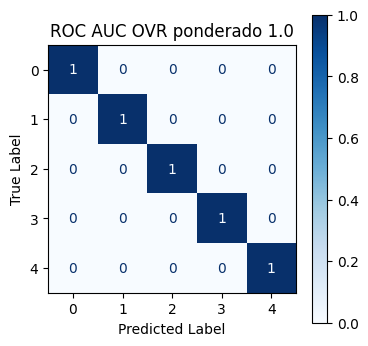

In [20]:
roc_auc = round(roc_auc_score(y_train, y_score, 
                            multi_class = 'ovr', 
                            average = 'weighted'), 2) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title(f'ROC AUC OVR ponderado {roc_auc}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Testing

In [21]:
y_pred = xgb.predict(X_test)
y_score = xgb.predict_proba(X_test)

cm = confusion_matrix(y_test.tolist(), y_pred.tolist())
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100

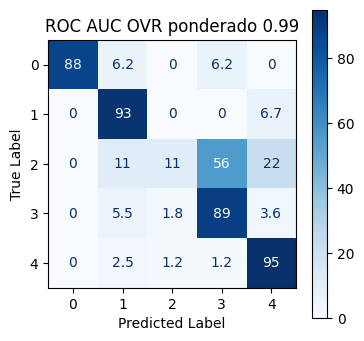

In [22]:
roc_auc = round(roc_auc_score(y_test, y_score, 
                            multi_class = 'ovr', 
                            average = 'weighted'), 2) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap=plt.cm.Blues)

plt.title(f'ROC AUC OVR ponderado {roc_auc}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
# Descripción de las clases
clases_list = { 0:'Class01', 
                1:'Class02',
                2:'Class03',
                3:'Class04',
                4:'Class05'}

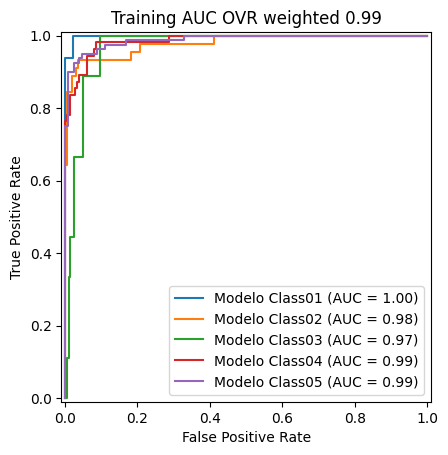

In [24]:
## ROC AUC
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_train = label_binarizer.transform(y_test)


roc_auc = round(roc_auc_score(y_test, y_score, multi_class = 'ovr', average = 'weighted'), 2)    
    

fig, ax = plt.subplots()

for key, value in clases_list.items():

    RocCurveDisplay.from_predictions(y_onehot_train[:, key], y_score[:, key], ax=ax, name=f'Modelo {value}')



ax.set_title(f'Training AUC OVR weighted {roc_auc}')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.show()



### Feature Importance

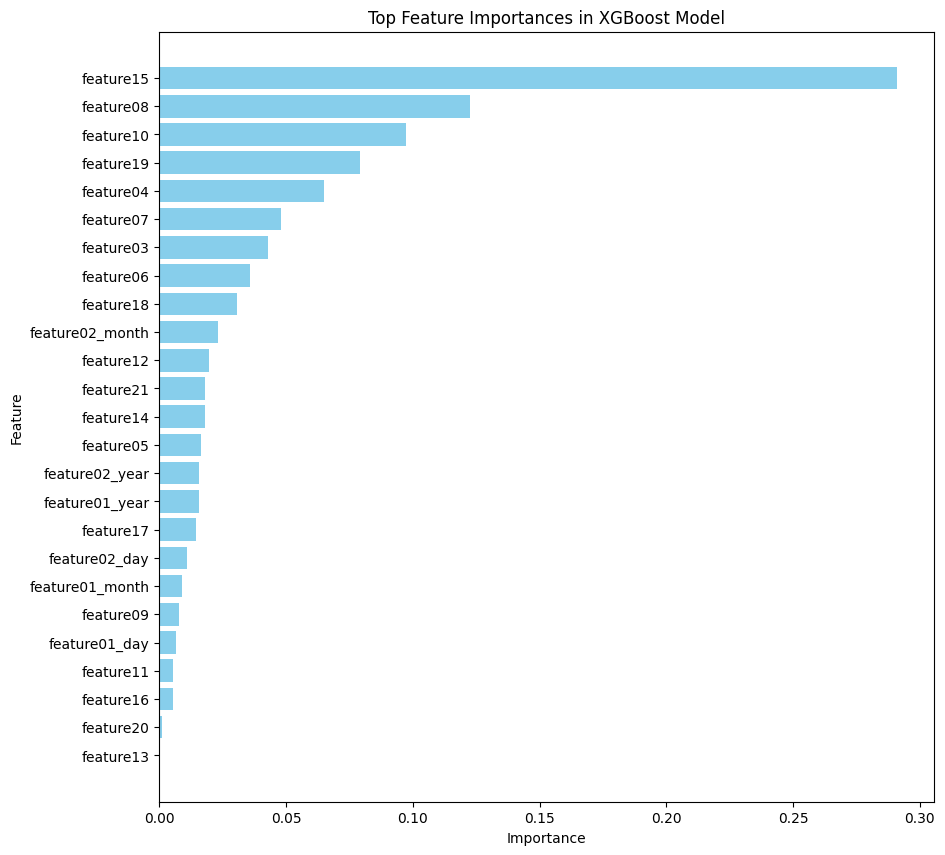

In [25]:
importances = xgb.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'][:50], feature_importance_df['Importance'][:50], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances in XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

Conclusiones:
- El modelo es bueno prediciendo datos nuevos, las variables más importantes son las 15, 14 y 10. Sin embargo el modelo no tiene un buen accuracy predicciendo la clase minoritaria. Se recomienda recopilar más casos de esa clase para añadirlos al entrenamiento